# Projeto de Conversor Forward com Malha Fechada

Este notebook mostra um fluxo completo de projeto para um **conversor Forward isolado**:

1. definição de especificações;
2. cálculo inicial de `D`, `Lout` e `Cout`;
3. simulação em malha aberta;
4. controle em malha fechada com PI.

> Modelo simplificado para estudo: transformador ideal + retificação + filtro LC de saída.


In [10]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (("build-test", "python"), ("build", "python")):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

import time
import numpy as np
import matplotlib.pyplot as plt
import pulsim as ps

print(f"Pulsim version: {ps.__version__}")
print("=" * 60)
print("PROJETO DE CONVERSOR FORWARD COM MALHA FECHADA")
print("=" * 60)


Pulsim version: 0.3.3
PROJETO DE CONVERSOR FORWARD COM MALHA FECHADA


## 1) Especificações


In [11]:
# Entrada / saída
Vin_nom = 48.0
Vin_min = 40.0
Vin_max = 56.0
Vout_ref = 12.0
Pout = 72.0
Iout = Pout / Vout_ref

# Chaveamento
fsw = 100e3
Tsw = 1.0 / fsw

# Transformador (Np:Ns)
n_turns = 2.0  # step-down 2:1

# Ripple alvo
delta_i_frac = 0.30
delta_v_frac = 0.01

print("ESPECIFICACOES")
print("-" * 60)
print(f"Vin nominal: {Vin_nom:.1f} V")
print(f"Vin range:   {Vin_min:.1f} V .. {Vin_max:.1f} V")
print(f"Vout alvo:   {Vout_ref:.1f} V")
print(f"Pout:        {Pout:.1f} W")
print(f"Iout:        {Iout:.2f} A")
print(f"fsw:         {fsw/1e3:.1f} kHz")
print(f"Np:Ns:       {n_turns:.2f}:1")


ESPECIFICACOES
------------------------------------------------------------
Vin nominal: 48.0 V
Vin range:   40.0 V .. 56.0 V
Vout alvo:   12.0 V
Pout:        72.0 W
Iout:        6.00 A
fsw:         100.0 kHz
Np:Ns:       2.00:1


## 2) Cálculos iniciais do estágio de potência


In [12]:
# Forward ideal: Vout ~= D * (Vin / n)
Vsec_nom = Vin_nom / n_turns
D_nom = np.clip(Vout_ref / Vsec_nom, 0.05, 0.70)
D_min = np.clip(Vout_ref / (Vin_max / n_turns), 0.05, 0.70)
D_max = np.clip(Vout_ref / (Vin_min / n_turns), 0.05, 0.70)

# Indutor de saída (buck-like no secundário)
delta_I = max(delta_i_frac * Iout, 1e-6)
L_out = (Vsec_nom - Vout_ref) * D_nom * Tsw / delta_I

# Capacitor de saída (aprox triangular)
delta_V = delta_v_frac * Vout_ref
C_out_min = delta_I / (8.0 * fsw * delta_V)
C_out = max(220e-6, C_out_min)

R_load = Vout_ref / Iout

print("PROJETO INICIAL")
print("-" * 60)
print(f"D nominal:    {D_nom:.3f}")
print(f"D faixa:      {D_min:.3f} .. {D_max:.3f}")
print(f"Lout calc.:   {L_out*1e6:.1f} uH")
print(f"Cout minimo:  {C_out_min*1e6:.1f} uF")
print(f"Cout usado:   {C_out*1e6:.1f} uF")
print(f"Rload:        {R_load:.3f} ohm")


PROJETO INICIAL
------------------------------------------------------------
D nominal:    0.500
D faixa:      0.429 .. 0.600
Lout calc.:   33.3 uH
Cout minimo:  18.8 uF
Cout usado:   220.0 uF
Rload:        2.000 ohm


## 3) Construção do circuito Forward

Topologia simplificada usada aqui:

- primário chaveado por MOSFET low-side;
- transformador ideal `Np:Ns`;
- diodo retificador + diodo de roda livre no secundário;
- filtro `Lout/Cout` na saída.


In [13]:
def create_forward_circuit(Vin, turns_ratio, Lout, Cout, Rload, fsw, duty):
    ckt = ps.Circuit()

    # Nos
    n_in = ckt.add_node("in")
    n_pri_sw = ckt.add_node("pri_sw")
    n_sec = ckt.add_node("sec")
    n_rect = ckt.add_node("rect")
    n_out = ckt.add_node("out")
    n_ctrl = ckt.add_node("ctrl")

    # Entrada
    ckt.add_voltage_source("Vin", n_in, -1, Vin)

    # Chave primaria
    m = ps.MOSFETParams()
    m.vth = 2.0
    m.kp = 8.0
    m.g_off = 1e-7
    ckt.add_mosfet("M1", n_ctrl, n_pri_sw, -1, m)

    # Transformador ideal N:1 (primary:secondary)
    ckt.add_transformer("T1", n_in, n_pri_sw, n_sec, -1, turns_ratio)

    # Retificacao + roda livre
    ckt.add_diode("D_fwd", n_sec, n_rect, g_on=300.0, g_off=1e-9)
    ckt.add_diode("D_free", -1, n_rect, g_on=300.0, g_off=1e-9)

    # Filtro de saida
    ckt.add_inductor("Lout", n_rect, n_out, Lout)
    ckt.add_capacitor("Cout", n_out, -1, Cout)
    ckt.add_resistor("Rload", n_out, -1, Rload)

    # Bleeders evitam nos flutuantes com elementos ideais (melhora robustez)
    ckt.add_resistor("R_bleed_sec", n_sec, -1, 1e7)
    ckt.add_resistor("R_bleed_pri", n_pri_sw, n_in, 1e7)
    ckt.add_resistor("R_bleed_rect", n_rect, -1, 1e7)

    # PWM
    pwm = ps.PWMParams()
    pwm.v_high = 10.0
    pwm.v_low = 0.0
    pwm.frequency = fsw
    pwm.duty = duty
    ckt.add_pwm_voltage_source("Vpwm", n_ctrl, -1, pwm)

    nodes = {
        "n_in": n_in,
        "n_pri_sw": n_pri_sw,
        "n_sec": n_sec,
        "n_rect": n_rect,
        "n_out": n_out,
        "n_ctrl": n_ctrl,
    }
    return ckt, nodes


ckt_ol, nodes_ol = create_forward_circuit(Vin_nom, n_turns, L_out, C_out, R_load, fsw, D_nom)
print("Circuito Forward criado.")
print(f"Nos: {ckt_ol.num_nodes()} | branches: {ckt_ol.num_branches()} | size: {ckt_ol.system_size()}")


Circuito Forward criado.
Nos: 6 | branches: 5 | size: 11


## 4) Simulação em malha aberta


In [14]:
periods_ol = 800
dt = Tsw / 80.0
t_stop = periods_ol * Tsw

x0 = np.zeros(ckt_ol.system_size())


def run_transient_with_retries(circuit, t0, t1, dt_base, x_init):
    attempts = (
        (dt_base, 120),
        (dt_base * 0.75, 180),
        (dt_base * 0.50, 260),
    )

    last = ([], [], False, "Unknown failure")
    for dt_try, max_iters in attempts:
        newton = ps.NewtonOptions()
        newton.max_iterations = max_iters
        last = ps.run_transient(circuit, t0, t1, dt_try, x_init, newton)
        if last[2]:
            return last
    return last


print("Rodando malha aberta...")
start = time.time()

t_ol, x_ol, ok_ol, msg_ol = run_transient_with_retries(ckt_ol, 0.0, t_stop, dt, x0)

elapsed = time.time() - start
print(f"status: {'OK' if ok_ol else 'FALHA'}")
print(f"msg: {msg_ol}")
print(f"tempo: {elapsed:.2f} s")
print(f"pontos: {len(t_ol)}")


Rodando malha aberta...
status: OK
msg: Transient completed
tempo: 11.45 s
pontos: 242443


RESULTADOS MALHA ABERTA
------------------------------------------------------------
Vout medio:  11.985 V
Ripple Vout: 12.95 mV (0.108 %)
Erro DC:     -0.13 %


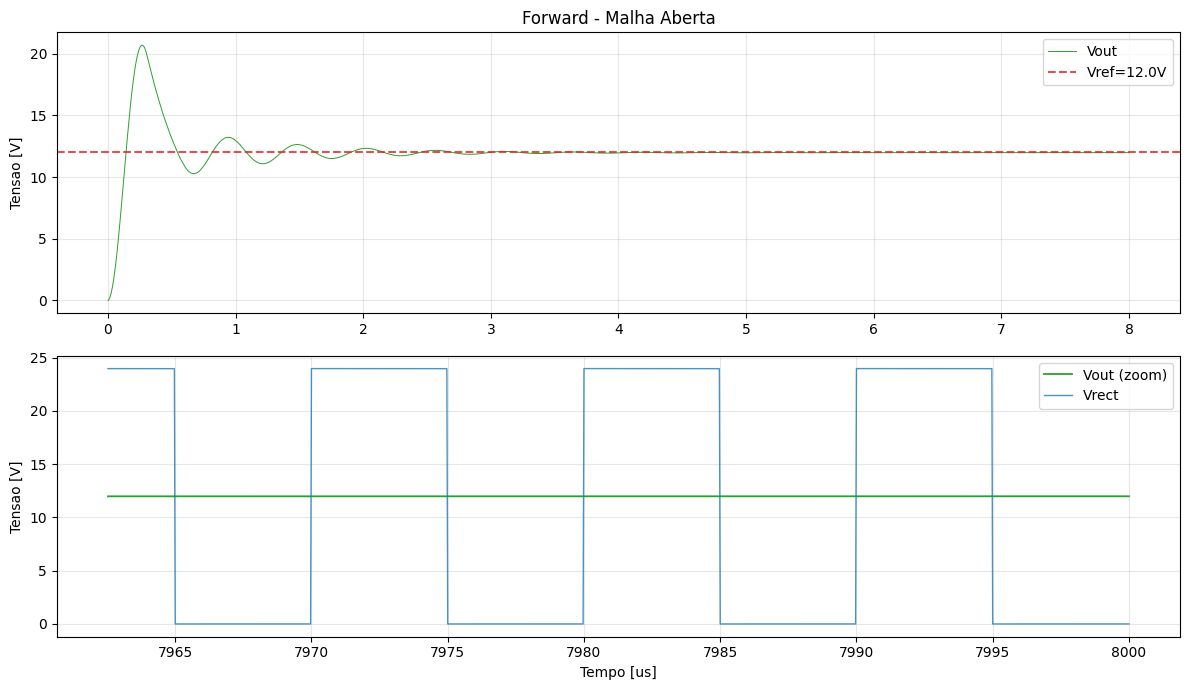

In [15]:
if ok_ol and len(t_ol) > 0:
    t_arr = np.array(t_ol)
    x_arr = np.array(x_ol)

    vout_ol = x_arr[:, nodes_ol["n_out"]]
    vrect_ol = x_arr[:, nodes_ol["n_rect"]]

    i0 = int(0.8 * len(vout_ol))
    vss = vout_ol[i0:]
    vout_mean_ol = float(np.mean(vss))
    vout_ripple_ol = float(np.max(vss) - np.min(vss))

    print("RESULTADOS MALHA ABERTA")
    print("-" * 60)
    print(f"Vout medio:  {vout_mean_ol:.3f} V")
    print(f"Ripple Vout: {vout_ripple_ol*1e3:.2f} mV ({100*vout_ripple_ol/max(vout_mean_ol,1e-9):.3f} %)" )
    print(f"Erro DC:     {100*(vout_mean_ol - Vout_ref)/Vout_ref:+.2f} %")

    n_zoom = max(200, int(15 * Tsw / dt))
    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=False)

    ax[0].plot(t_arr * 1e3, vout_ol, lw=0.7, color="tab:green", label="Vout")
    ax[0].axhline(Vout_ref, ls="--", color="tab:red", alpha=0.8, label=f"Vref={Vout_ref:.1f}V")
    ax[0].set_title("Forward - Malha Aberta")
    ax[0].set_ylabel("Tensao [V]")
    ax[0].grid(alpha=0.3)
    ax[0].legend()

    ax[1].plot(t_arr[-n_zoom:] * 1e6, vout_ol[-n_zoom:], lw=1.3, color="tab:green", label="Vout (zoom)")
    ax[1].plot(t_arr[-n_zoom:] * 1e6, vrect_ol[-n_zoom:], lw=1.0, color="tab:blue", alpha=0.8, label="Vrect")
    ax[1].set_xlabel("Tempo [us]")
    ax[1].set_ylabel("Tensao [V]")
    ax[1].grid(alpha=0.3)
    ax[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("Simulacao de malha aberta falhou.")


## 5) Malha fechada com PI


In [16]:
# Ganhos iniciais (tuning mais conservador para robustez)
Kp = 0.004
Ki = 20.0

D_CTRL_MIN = 0.05
D_CTRL_MAX = 0.65

print("CONTROLADOR PI")
print("-" * 60)
print(f"Kp={Kp}")
print(f"Ki={Ki}")
print(f"Duty limits: {D_CTRL_MIN:.2f} .. {D_CTRL_MAX:.2f}")


CONTROLADOR PI
------------------------------------------------------------
Kp=0.004
Ki=20.0
Duty limits: 0.05 .. 0.65


In [17]:
def simulate_forward_closed_loop(
    Vin,
    turns_ratio,
    Lout,
    Cout,
    Rload,
    fsw,
    Vref,
    Kp,
    Ki,
    periods=700,
    dt_factor=80,
    duty_init=None,
    duty_min=0.05,
    duty_max=0.65,
    duty_slew=0.008,
    control_periods=2,
    feedback_alpha=0.97,
    duty_window=0.08,
    softstart_periods=120,
):
    """
    Forward em malha fechada com PI no backend mixed-domain.

    Estratégia para robustez:
    - circuito único ao longo da simulação;
    - feedforward de duty + correção PI;
    - feedback filtrado;
    - atualização de controle desacoplada do PWM.
    """
    Tsw = 1.0 / fsw
    dt_base = Tsw / dt_factor
    control_periods = max(1, int(control_periods))

    duty_ff_nom = float(np.clip((Vref * turns_ratio) / max(Vin, 1e-6), duty_min, duty_max))
    if duty_init is None:
        duty_init = duty_ff_nom

    # PI no backend (saida = correção de duty)
    ctrl = ps.Circuit()
    n_ref_ctrl = ctrl.add_node("v_ref")
    n_fb_ctrl = ctrl.add_node("v_fb")
    n_aux_ctrl = ctrl.add_node("u_ctrl")
    ctrl.add_virtual_component(
        "pi_controller",
        "PI_LOOP",
        [n_ref_ctrl, n_fb_ctrl, n_aux_ctrl],
        {
            "kp": float(Kp),
            "ki": float(Ki),
            "output_min": -float(duty_window),
            "output_max": float(duty_window),
            "anti_windup": 1.0,
        },
        {},
    )
    x_ctrl = np.zeros(ctrl.system_size())

    time_hist = []
    vout_hist = []
    vout_filt_hist = []
    duty_hist = []
    error_hist = []
    vref_hist = []

    current_duty = float(np.clip(duty_init, duty_min, duty_max))
    t = 0.0
    vout_filtered = None

    # Mantem o mesmo circuito para preservar estados internos
    ckt, nodes = create_forward_circuit(Vin, turns_ratio, Lout, Cout, Rload, fsw, current_duty)
    x = np.zeros(ckt.system_size())

    for period in range(periods):
        vref_eff = Vref * min(1.0, (period + 1) / max(1, softstart_periods))
        duty_ff = float(np.clip((vref_eff * turns_ratio) / max(Vin, 1e-6), duty_min, duty_max))

        newton = ps.NewtonOptions()
        newton.max_iterations = 140
        times, states, ok, msg = ps.run_transient(
            ckt,
            t,
            t + Tsw,
            dt_base,
            x,
            newton,
        )

        if not ok:
            rescue = ps.NewtonOptions()
            rescue.max_iterations = 320
            times, states, ok, msg = ps.run_transient(
                ckt,
                t,
                t + Tsw,
                dt_base * 0.5,
                x,
                rescue,
                robust=False,
                auto_regularize=True,
            )

        if not ok:
            return {
                "success": False,
                "message": f"Falha no periodo {period}: {msg}",
                "time": np.array(time_hist),
                "vout": np.array(vout_hist),
                "vout_filtered": np.array(vout_filt_hist),
                "duty": np.array(duty_hist),
                "error": np.array(error_hist),
                "vref_eff": np.array(vref_hist),
            }

        states_arr = np.array(states)
        x = states_arr[-1].copy()
        t += Tsw

        vout_period = float(np.mean(states_arr[:, nodes["n_out"]]))
        if vout_filtered is None:
            vout_filtered = vout_period
        else:
            vout_filtered = feedback_alpha * vout_filtered + (1.0 - feedback_alpha) * vout_period

        if period % control_periods == 0:
            x_ctrl[n_ref_ctrl] = vref_eff
            x_ctrl[n_fb_ctrl] = vout_filtered
            ctrl_step = ctrl.execute_mixed_domain_step(x_ctrl, t)
            duty_corr = float(ctrl_step.channel_values["PI_LOOP"])
            duty_target = float(np.clip(duty_ff + duty_corr, duty_min, duty_max))
            duty_delta = np.clip(duty_target - current_duty, -duty_slew, duty_slew)
            current_duty = float(np.clip(current_duty + duty_delta, duty_min, duty_max))
            ckt.set_pwm_duty("Vpwm", current_duty)

        error = vref_eff - vout_filtered

        time_hist.append(t * 1e3)
        vout_hist.append(vout_period)
        vout_filt_hist.append(vout_filtered)
        duty_hist.append(current_duty)
        error_hist.append(error)
        vref_hist.append(vref_eff)

        if period < 5 or period % 100 == 0:
            print(
                f"  Periodo {period}: Vout={vout_period:.2f}V, "
                f"Vout_filt={vout_filtered:.2f}V, D={current_duty:.3f}"
            )

    return {
        "success": True,
        "message": "OK",
        "time": np.array(time_hist),
        "vout": np.array(vout_hist),
        "vout_filtered": np.array(vout_filt_hist),
        "duty": np.array(duty_hist),
        "error": np.array(error_hist),
        "vref_eff": np.array(vref_hist),
    }


print("SIMULACAO EM MALHA FECHADA")
print("=" * 50)
print(f"V_ref = {Vout_ref:.1f}V")

res_cl = simulate_forward_closed_loop(
    Vin=Vin_nom,
    turns_ratio=n_turns,
    Lout=L_out,
    Cout=C_out,
    Rload=R_load,
    fsw=fsw,
    Vref=Vout_ref,
    Kp=Kp,
    Ki=Ki,
    periods=700,
    dt_factor=80,
    duty_init=D_nom,
    duty_min=D_CTRL_MIN,
    duty_max=D_CTRL_MAX,
    duty_slew=0.008,
    control_periods=2,
    feedback_alpha=0.97,
    duty_window=0.08,
    softstart_periods=120,
)

print(f"status: {'OK' if res_cl['success'] else 'FALHA'}")
print(f"msg: {res_cl['message']}")


SIMULACAO EM MALHA FECHADA
V_ref = 12.0V
  Periodo 0: Vout=0.05V, Vout_filt=0.05V, D=0.492
  Periodo 1: Vout=0.24V, Vout_filt=0.05V, D=0.492
  Periodo 2: Vout=0.59V, Vout_filt=0.07V, D=0.484
  Periodo 3: Vout=1.08V, Vout_filt=0.10V, D=0.484
  Periodo 4: Vout=1.70V, Vout_filt=0.15V, D=0.476
  Periodo 100: Vout=7.47V, Vout_filt=7.69V, D=0.358
  Periodo 200: Vout=11.58V, Vout_filt=11.44V, D=0.493
  Periodo 300: Vout=11.84V, Vout_filt=11.90V, D=0.496
  Periodo 400: Vout=11.92V, Vout_filt=11.92V, D=0.498
  Periodo 500: Vout=12.05V, Vout_filt=12.02V, D=0.500
  Periodo 600: Vout=12.43V, Vout_filt=12.06V, D=0.500
status: OK
msg: OK


RESULTADOS MALHA FECHADA
------------------------------------------------------------
Vout medio (filtrado): 11.986 V
Erro medio:            -0.12 %
Duty medio:            50.05 %


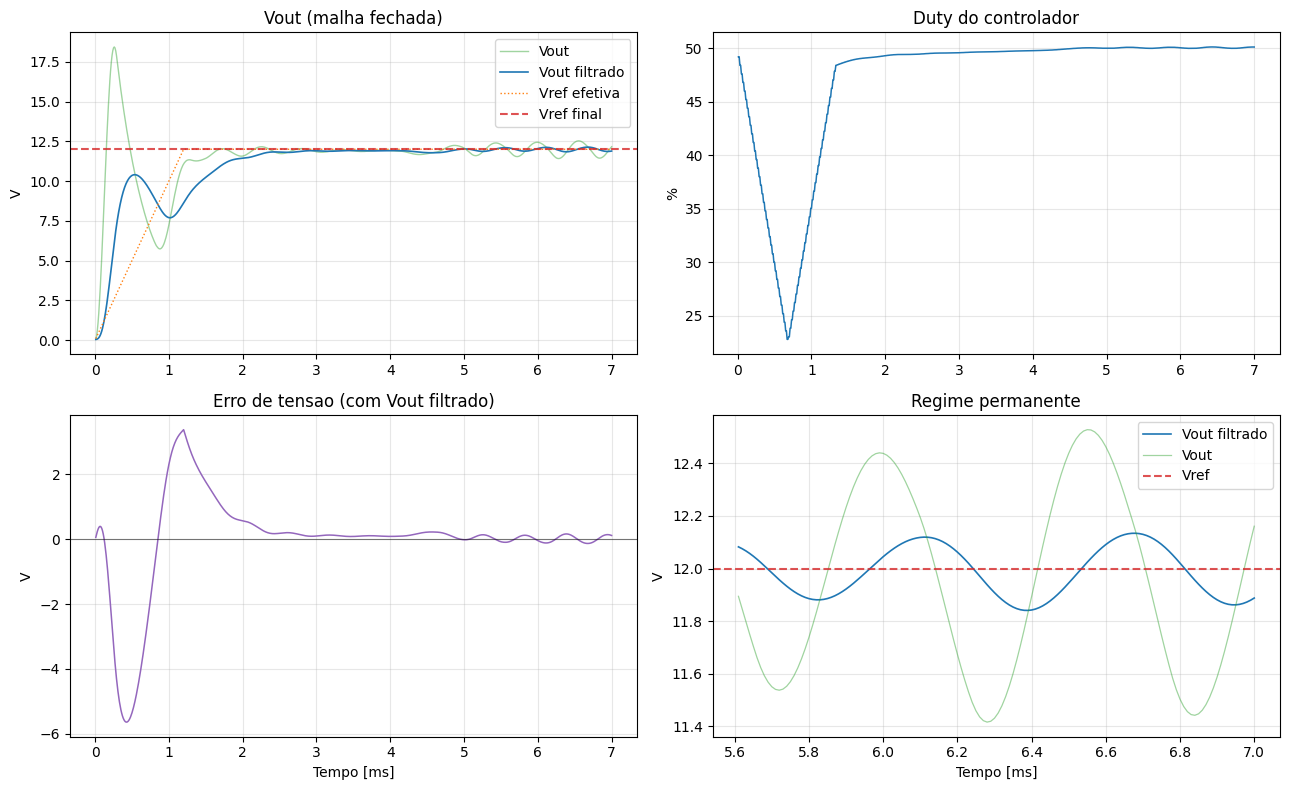

In [18]:
if res_cl["success"] and len(res_cl["vout"]) > 0:
    t_cl = res_cl["time"]
    v_cl = res_cl["vout"]
    v_f_cl = res_cl.get("vout_filtered", v_cl)
    d_cl = res_cl["duty"]
    e_cl = res_cl["error"]
    vref_eff = res_cl.get("vref_eff", np.full_like(v_cl, Vout_ref))

    i0 = int(0.8 * len(v_cl))
    vss = v_f_cl[i0:]
    dss = d_cl[i0:]

    vout_mean_cl = float(np.mean(vss))
    duty_mean_cl = float(np.mean(dss))
    err_pct_cl = 100.0 * (vout_mean_cl - Vout_ref) / Vout_ref

    print("RESULTADOS MALHA FECHADA")
    print("-" * 60)
    print(f"Vout medio (filtrado): {vout_mean_cl:.3f} V")
    print(f"Erro medio:            {err_pct_cl:+.2f} %")
    print(f"Duty medio:            {100*duty_mean_cl:.2f} %")

    fig, ax = plt.subplots(2, 2, figsize=(13, 8))

    ax[0, 0].plot(t_cl, v_cl, color="tab:green", lw=1.0, alpha=0.45, label="Vout")
    ax[0, 0].plot(t_cl, v_f_cl, color="tab:blue", lw=1.2, label="Vout filtrado")
    ax[0, 0].plot(t_cl, vref_eff, color="tab:orange", ls=":", lw=1.0, label="Vref efetiva")
    ax[0, 0].axhline(Vout_ref, color="tab:red", ls="--", alpha=0.8, label="Vref final")
    ax[0, 0].set_title("Vout (malha fechada)")
    ax[0, 0].set_ylabel("V")
    ax[0, 0].grid(alpha=0.3)
    ax[0, 0].legend()

    ax[0, 1].plot(t_cl, 100.0 * d_cl, color="tab:blue", lw=1.1)
    ax[0, 1].set_title("Duty do controlador")
    ax[0, 1].set_ylabel("%")
    ax[0, 1].grid(alpha=0.3)

    ax[1, 0].plot(t_cl, e_cl, color="tab:purple", lw=1.1)
    ax[1, 0].axhline(0.0, color="k", lw=0.8, alpha=0.5)
    ax[1, 0].set_title("Erro de tensao (com Vout filtrado)")
    ax[1, 0].set_xlabel("Tempo [ms]")
    ax[1, 0].set_ylabel("V")
    ax[1, 0].grid(alpha=0.3)

    ax[1, 1].plot(t_cl[i0:], v_f_cl[i0:], color="tab:blue", lw=1.2, label="Vout filtrado")
    ax[1, 1].plot(t_cl[i0:], v_cl[i0:], color="tab:green", lw=0.9, alpha=0.45, label="Vout")
    ax[1, 1].axhline(Vout_ref, color="tab:red", ls="--", alpha=0.8, label="Vref")
    ax[1, 1].set_title("Regime permanente")
    ax[1, 1].set_xlabel("Tempo [ms]")
    ax[1, 1].set_ylabel("V")
    ax[1, 1].grid(alpha=0.3)
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("Simulacao em malha fechada falhou.")


## 6) Resumo

Com esse notebook, voce tem um ponto de partida para projeto de Forward:

- dimensao inicial de `Lout` e `Cout`;
- avaliacao em malha aberta;
- fechamento de malha com PI ajustando duty em tempo de simulacao.

Proximos passos recomendados:

1. incluir modelo de perdas (MOSFET/diodo/transformador);
2. varrer `Vin_min..Vin_max` e degraus de carga;
3. comparar com LTspice para validar forma de onda e dinamica.
